# Bayesian Multilevel Modelling using PyStan

This is a tutorial, following through Chris Fonnesbeck's [primer on using PyStan with Bayesian Multilevel Modelling](http://mc-stan.org/documentation/case-studies/radon.html).

# 10. Partial Pooling - Varying Slope and Intercept

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import seaborn as sns

import clean_data
import pooled_model
import unpooled_model

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Teaching/Teaching-Stan-Hierarchical-Modelling/venv-Teaching-Stan-Hierarchical/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0ac21a09143e1678f06ad0a8c64d4c81 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_56b08b63d48247e5e31d7c6f26b156c8 NOW.


## Partial pooling: varying intercept and slope

The most general way to extend partial pooling to this linear model is to allow both slope and intercept to vary by county. That is to model the relationship between measured log(radon), the prevailing radon level, and the effect of the floor at which the measurement was made, *where the county affects both the prevailing radon level and the effect of making the measurement at different floors*. 

In this linear model, the measured radon level in a household $y_i$ is a function of the floor at which measurement took place, $x_i$, with parameters $\alpha_{j[i]}$ (the prevailing radon level in the county) and $\beta_{j[i]}$ (the influence of the floor, which varies by county), and residual error $\epsilon_i$.

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \epsilon_i$$

In this linear model, the prevailing radon level $\alpha_{j[i]}$ is the intercept, with random Normal effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

and the floor effect $\beta_{j[i]}$ is the slope, with random Normal effect:

$$\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$

The residual error is also sampled from a Normal distribution:

$$\epsilon_i \sim N(0, \sigma_y^2)$$


### Specifying the model

We define the model in `stan`, as usual specifying `data`, `parameters`, `transformed parameters` and `model` blocks. The model is built up as follows.

Our observed log(radon) measurements ($y$) approximate an intermediate transformed parameter $\hat{y}$, which is normally distributed with variance $\sigma_y^2$. $\sigma_y$ is sampled from a Uniform distribution.

$$y \sim N(\hat{y}, \sigma_y^2)$$
$$\sigma_{y} \sim U(0, 100)$$

The transformed variable $\hat{y}$ is a linear function of $x_i$, the floor at which radon is measured. The parameters are the value of $\alpha$ associated with the county $i$ ($i=1,\ldots,N$) in which each household is found, and the effect due to which floor is used for measurement.

$$\hat{y_i} = {\alpha_{j[i]} + \beta_{j[i]} x_i}$$

The value of $\alpha$ for each county $j[i]$, is Normally distributed with mean $\mu_{\alpha}$ and variance $\sigma_{\alpha}^2$. $\sigma_{\alpha}$ is sampled from a Uniform distribution, between 0 and 100. $\mu_{\alpha}$ is an unconstrained real value. There is a common mean and variance underlying each of the prevailing radon levels in each county.

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$

The value of $\beta$ for each county $j[i]$, is Normally distributed with mean $\mu_{\beta}$ and variance $\sigma_{\beta}^2$. $\sigma_{\beta}$ is sampled from a Uniform distribution, between 0 and 100. $\mu_{\beta}$ is an unconstrained real value. There is a common mean and variance underlying each of the floor effects for each county.

$$\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\sigma_{\beta} \sim U(0, 100)$$


In `data`:
* `J` is the number of counties (`int`)
* `N` is the number of samples (`int`)
* `county` is a list of `N` values from 1-85, specifying the county index each measurement
* `x` is a `vector` of indices for which floor the radon measurements were taken at each household
* `y` is a `vector` of log(radon) measurements, one per household/sample.

We define parameters:

* `a` (`vector`, one value per county), representing $\alpha$, the vector of prevailing radon levels for each county.
* `mu_a`, a `real` corresponding to $\mu_{\alpha}$, the mean radon level underlying the distribution from which the county levels are drawn.
* `sigma_a` is $\sigma_{\alpha}$, the standard deviation of the radon level distribution underlying the county levels: variability of county means about the average.
* `b` (`vector`, one value per county), representing $\beta$, the vector of floor effects for each county.
* `mu_b`, a `real` corresponding to $\mu_{\beta}$, the mean floor effect underlying the distribution from which the county levels are drawn.
* `sigma_b` is $\sigma_{\beta}$, the standard deviation of the floor effect distribution underlying the county level effects: variability of county means about the average.
* `sigma_y` is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations.

In [2]:
varying_intercept_slope = """
data {
  int<lower=0> J;
  int<lower=0> N;
  int<lower=1,upper=J> county[N];
  vector[N] x;
  vector[N] y;
}
parameters{
  vector[J] a;
  real mu_a;
  vector[J] b;
  real mu_b;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_y;
}
transformed parameters {
  vector[N] y_hat;
  for(i in 1:N)
    y_hat[i] <- a[county[i]] + x[i] * b[county[i]];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal(mu_a, sigma_a);

  sigma_b ~ uniform(0, 100);
  b ~ normal(mu_b, sigma_b);
    
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

### Fitting the model

Again, we map Python variables to those in the model, and run the fit:

In [3]:
n_county = clean_data.srrs_mn.groupby('county')['idnum'].count()  # number of samples from each county

varying_intercept_slope_data = {'N': len(clean_data.log_radon),
                                'J': len(n_county),
                                'county': clean_data.county + 1,
                                'x': clean_data.floor_measure,
                                'y': clean_data.log_radon}

varying_intercept_slope_fit = pystan.stan(model_code=varying_intercept_slope,
                                          data=varying_intercept_slope_data,
                                          iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_936a8c95e985152a506b3748798da449 NOW.


We can then collect the county-level mean estimates of prevailing radon level (*intercept*) as `bp` and floor effect (*slope*) as `mp`:

In [4]:
b_sample = varying_intercept_slope_fit['a']
m_sample = varying_intercept_slope_fit['b']
bp = b_sample.mean(axis=0)
mp = m_sample.mean(axis=0)

## Interpreting the model output

We can visualise the distribution of the parameter estimates, by county, with a boxplot:

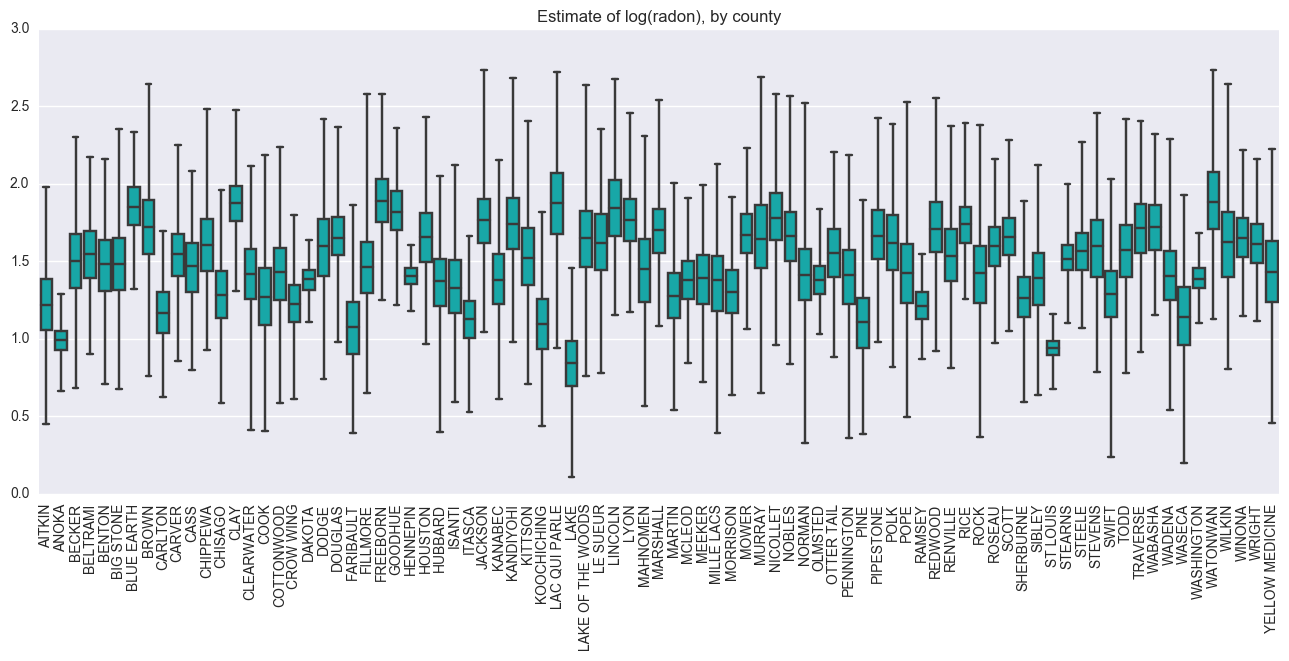

In [5]:
# Boxplot of estimated log(radon) level by county
plt.figure(figsize=(16, 6))
g = sns.boxplot(data=b_sample, whis=np.inf, color="c")
g.set_xticklabels(clean_data.mn_counties, rotation=90)  # label counties
g.set_title("Estimate of log(radon), by county")
g;

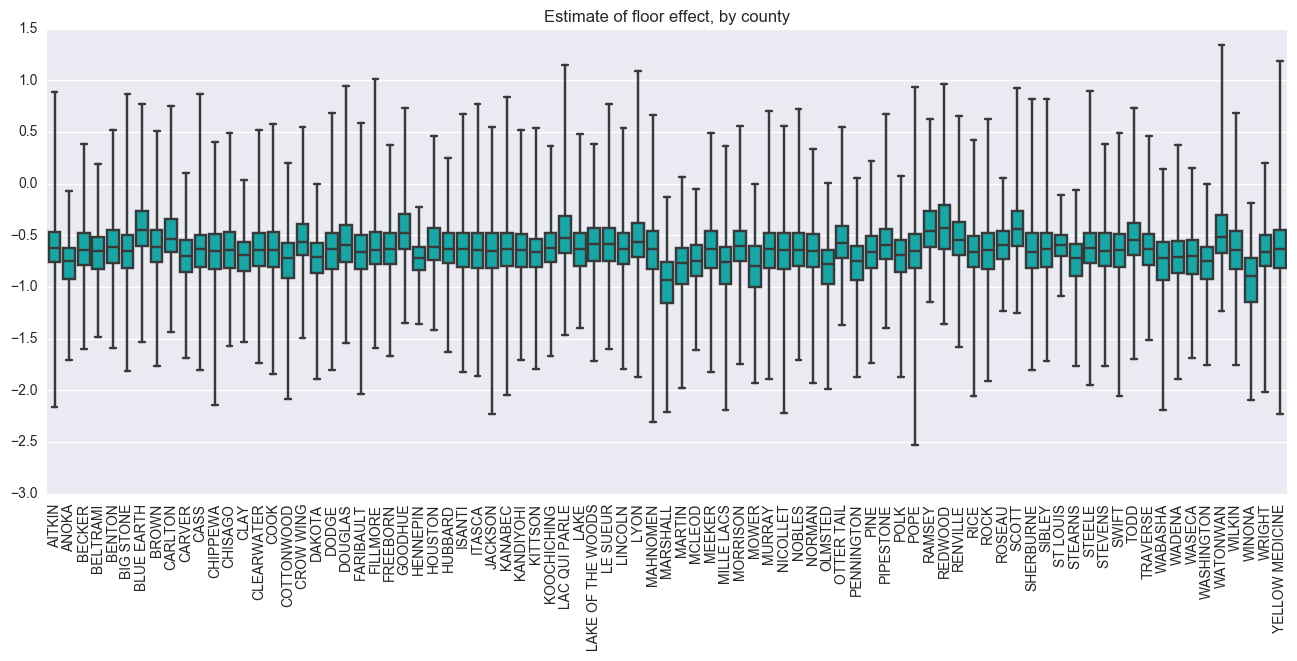

In [6]:
# Boxplot of estimated floor effect by county
plt.figure(figsize=(16, 6))
g = sns.boxplot(data=m_sample, whis=np.inf, color="c")
g.set_xticklabels(clean_data.mn_counties, rotation=90)  # label counties
g.set_title("Estimate of floor effect, by county")
g;

These estimates appear to correspond quite well to those we obtained in earlier notebooks. To see how the combined estimates have changed, we plot the implied linear relationships for each county, as before:

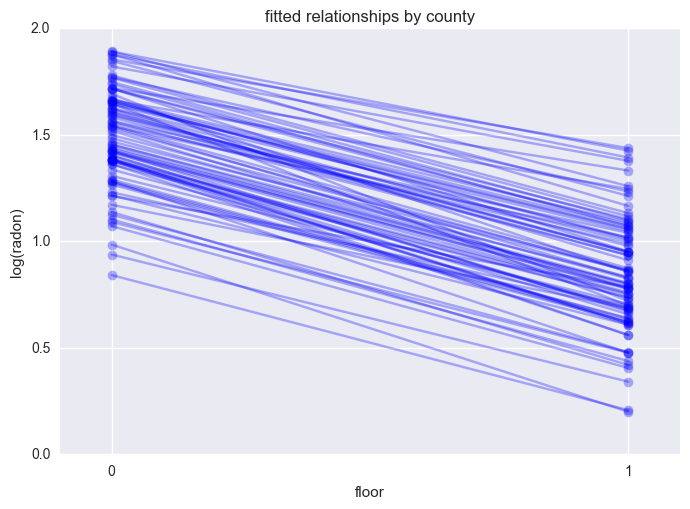

In [7]:
xvals = np.arange(2)  # floor
for mi, bi in zip(mp, bp):
    plt.plot(xvals, mi * xvals + bi, 'bo-', alpha=0.3)
plt.xticks([0, 1])
plt.xlim(-0.1, 1.1)
plt.ylim(0, 2)
plt.title("fitted relationships by county")
plt.xlabel("floor")
plt.ylabel("log(radon)");

While these relationships are all very similar we can see that by allowing floor effect and prevailing radon level both to vary, we seem to be capturing more of the natural variation, a bit more accurately.

We can see whether partial pooling of both parameter estimates has provided objectively more reasonable estimates than pooled or unpooled models, for counties with small sample sizes:

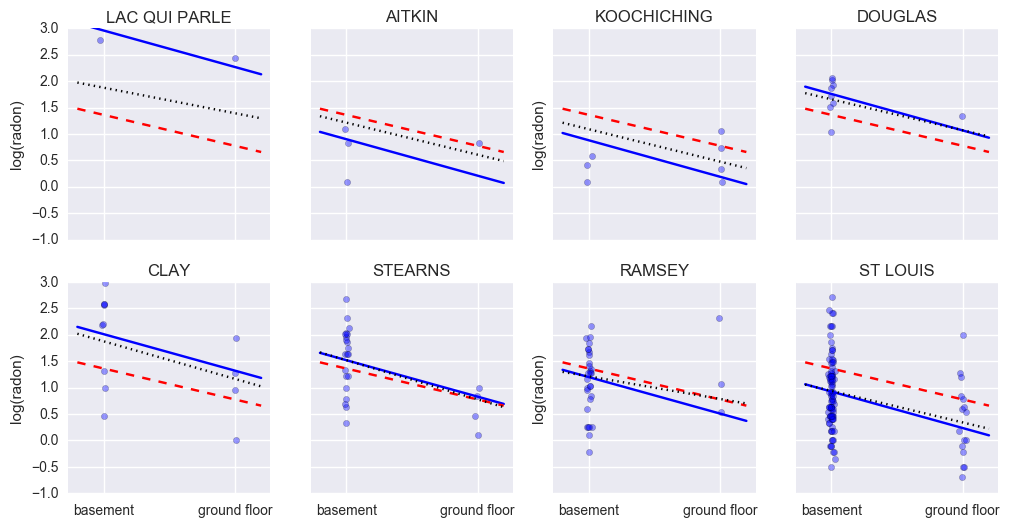

In [8]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                   'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i, c in enumerate(sample_counties):
    # raw data
    y = clean_data.srrs_mn.log_radon[clean_data.srrs_mn.county == c]
    x = clean_data.srrs_mn.floor[clean_data.srrs_mn.county == c]

    # unpooled fit
    m = unpooled_model.unpooled_estimates[c]
    b = unpooled_model.unpooled_fit['beta'].mean()
    
    # plot data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)        # raw data
    axes[i].plot(xvals, b * xvals + m, 'b-')                                 # unpooled fit
    axes[i].plot(xvals, pooled_model.m0 * xvals + pooled_model.b0, 'r--')    # pooled fit
    axes[i].plot(xvals, mp[clean_data.county_lookup[c]] *
                 xvals + bp[clean_data.county_lookup[c]], 'k:')  # partial pooling fit
    
    # plot labels
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['basement', 'ground floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel('log(radon)')

Comparisons against the pooled (red dashed line), the unpooled (blue solid line), and partially-pooled (black dotted line) show that for counties with many datapoints the fits are very similar, but where the counties have few datapoints, the partially-pooled fits are not as extreme. The slopes also vary slightly, but not very greatly, from the fits where a single slope is assumed to apply state-wide.